In [1]:
import scipy.io
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import glob
import os
import re
from pathlib import Path
import datetime
import math
import swifter
import math
from scipy import stats
import itertools
from collections import Counter
from statannotations.Annotator import Annotator
import gcmi
import seaborn as sns
# pd.set_option('display.max_rows', None)
plt.rc('xtick',labelsize=12)
plt.rc('ytick',labelsize=12)

In [2]:
import matplotlib as mpl
mpl.rcParams['font.family'] = 'Arial'

In [3]:
def preprocess_meta_data_raw(df):
    timepoints=['BI', '4D','7D','10D','12D', '14D', '15D', '16D', '25D']
    epochs=['REM', 'SN', 'VC', 'SLEEP','RUN']
    splitted_path=df.path.split('/')
    name_group = [s for s in splitted_path if "Group" in s][0]
    group = int(list(filter(str.isdigit, name_group))[-1]) 
    
    # covnert rats name to their sham or non sham type
    convert_func = np.vectorize(lambda x: type_rat.get(x, ''))
    # remove spaces and convert RAT to R in each name
    name = name_group.split('_')[0].replace(" ", "").replace("AT", "")
    if name =='R12':
        name ='R012'
    df['rat']=name
    df['group']=group
    df['timepoint']=[s for s in splitted_path if s in timepoints][0]
    df['epoch']=splitted_path[-2]                                                 
    df['rat type']=str(convert_func(name))
    if 'Matrix_2D.mat' in splitted_path[-1]:
        df['file_type']= 'mat2d'
    else:
         df['file_type']= splitted_path[-1]
    return df

In [4]:
def preprocess_meta_data(df):
    timepoints=['BI', '4D','7D','10D','12D', '14D', '15D', '16D', '25D']
    epochs=['REM', 'SN', 'VC', 'SLEEP','RUN']
    splitted_path=df.path.split('/')
    
    name_group = [s for s in splitted_path if "Group" in s][0]
    group = int(list(filter(str.isdigit, name_group))[-1]) 
    
#     covnert rats name to their sham or non sham type
    convert_func = np.vectorize(lambda x: type_rat.get(x, ''))
#     remove spaces and convert RAT to R in each name
    name = name_group.split('_')[0].replace(" ", "").replace("AT", "")
    if name =='R12':
        name ='R012'
    df['rat']=name
    df['group']=group
    df['timepoint']=[s for s in splitted_path if s in timepoints][0]
    
#     df['epoch']=[item for item in epochs for s in splitted_path if item.upper() in s.upper()][0]
#     if item.upper() in s.upper()
    df['epoch']=splitted_path[-2]
    df['rat type']=str(convert_func(name))
    return df

In [5]:
def load_data(df):
    fpath=df.path
    mat_data = scipy.io.loadmat(fpath)
    mdata = mat_data['Otot']  # variable in mat file 
    # covnert connections to ROIs names
    group=df.group
    convert_func = np.vectorize(lambda x: groups_ROIs[group].get(x, ''))
    
    # extracting order information
    dic_data={}
    for order in range(3,6):
        for name in mdata.dtype.names:
            column_data=mdata[name][0]
            if column_data[order-1].size!=0:
                dic_data[name + '_' + str(order)]=convert_func(column_data[order-1])
                    
            else:
                dic_data[name + '_' + str(order)]=np.nan
    return pd.Series(dic_data)

In [6]:
def sort_date(order,timepoints):
    timepoints=sorted(timepoints, key=lambda x: order.index(x))
    return timepoints

In [7]:
def load_data_raw(df):
    dict_data={}
    fpath=df.path
    mat_data = scipy.io.loadmat(fpath)
    try:
        mdata = mat_data['Matrix_2D'] # variable in mat file
        max_timepoint= mat_data['Matrix_2D'].shape[0]
    except:
        mdata = mat_data['Averaged_Samples'] # variable in mat file
        max_timepoint= mat_data['Averaged_Samples'].shape[0]

    return pd.Series({'data':mdata,'data length':max_timepoint})

In [8]:
palette_time = {"BI":"#e60049",
                "4D":"#0bb4ff", 
                "7D":"#50e991",
                "10D":"#e6d800",
                "12D":"#9b19f5",
                "14D":"#ffa300",
                "15D":"#dc0ab4",
                "16D":"#b3d4ff",
                "25D":"#00bfa0"}


In [9]:
palette_epoch = {"'REST'":'#E24A33',
                "'SNIFFING'":'#358ABD',
                "'SLEEP'":'green',
                'REM Sleep':'yellow',
                'Running':'darkviolet'}

# Constant

In [10]:
rats_names=['R012', 'R304', 'R305', 'R391', 'R303', 'R319', 'R347', 'R358']
DIR_path=Path(os.getcwd()).parent
SAVE_PATH=DIR_path / 'figures' / datetime.date.today().strftime('%Y_%m_%d')

SAVE_PATH_FIG=DIR_path /'results' / datetime.date.today().strftime('%Y_%m_%d') /'figures'
SAVE_PATH_ANALYSIS=DIR_path /'results' / datetime.date.today().strftime('%Y_%m_%d') /'analysis'

# analysis_group='group' # either group or rat
# group_condition=8
# SAVE_PATH=SAVE_PATH 
timepoints=['BI', '4D','7D','10D','12D', '14D', '15D', '16D', '25D']
all_timepoints=['D-7', 'D4','D7','D10','D12', 'D14', 'D15', 'D16', 'D25']

In [11]:
for i in [3,5]:
    if not os.path.exists(SAVE_PATH_FIG/ f'group {i}'/'raw_data'):
        os.makedirs(SAVE_PATH_FIG/ f'group {i}'/'raw_data')

In [13]:
type_rat={
    'R391':'Sham/SE',
    'R012':'Sham',
    'R304':'Sham',
    'R305':'Sham',
    'R303':'Sham',
    'R358':'Sham/SE',
    'R319':'NSE',
    'R347':'SE',
    'R322':'SE',
    'R326':'SE',
    'R011':'Sham',
    'PILO1':'SE',
    'PILO2':'SE',
    'PILO3':'SE',
    'R322':'SE',
    'R326':'SE'
         }

In [14]:
groups_ROIs={}
groups_ROIs[1]={
    1:'MS',
    2:'Thal',
    3:'SuM',
    4:'dHPC',
    5:'Subi',
    6:'EC',
    7:'PCC'
   }

groups_ROIs[2]={
    1:'MS',
    2:'dHPC',
    3:'Subi',
    4:'vHPC',
    5:'EC'
}

groups_ROIs[3]={
    1:'MS',
    2:'SuM',
    3:'dHPC',
    4:'EC'
}

groups_ROIs[4]={
    1:'MS',
    2:'dHPC',
    3:'EC'
}

groups_ROIs[5]={
    1:'MS',
    2:'dHPC',
    3:'vHPC',
    4:'Thal'
}

groups_ROIs[6]={
    1:'MS',
    2:'PCC',
    3:'Thal',
    4:'SuM',
    5:'Subi',
    6:'EC'
   }

groups_ROIs[7]={
    1:'MS',
    2:'Thal',
    3:'dHPC',
    4:'vHPC',
    5:'EC',
   }

groups_ROIs[8]={
    1:'MS',
    2:'Thal',
    3:'PCC',
    4:'dHPC',
    5:'vHPC',
    6:'EC'
   }


In [15]:
def rename_epoch(epoch_name):
    if epoch_name=='VC':
        return "REST"
    elif epoch_name=='SN':
        return "SN"
    elif epoch_name=='SLEEP':
        return "SLEEP"
    elif epoch_name=='REM':
        return 'REM Sleep'
    elif epoch_name=='RUN':
        return 'Running'

In [16]:
def convert_epochs(epoch_name):
    for epoch in epochs:
        if epoch.upper() in epoch_name.upper():
            return epoch
    return epoch_name

In [17]:
def extract_id_epoch(epoch_name):
    p = '[\d]+[.,\d]+|[\d]*[.][\d]+|[\d]+'
    if re.search(p, epoch_name) is not None:
        for catch in re.finditer(p, epoch_name):
            return int(catch[0]) # catch is a match object

In [18]:
def remove_sham_rats(df,time):
#     if time == 'BI':
#         df_sham=df[(df['rat type']=='Sham')]
#         df_sham_se=df[(df['rat type']=='Sham/SE')]
#         df_nse=df[(df['rat type']=='NSE')]
        
#         df_analyse=pd.concat([df_sham,df_sham_se,df_nse])
        
#     else:
    df_se=df[(df['rat type']=='SE')]
    df_sham_se=df[(df['rat type']=='Sham/SE')]
    df_analyse=pd.concat([df_se,df_sham_se])
    return df_analyse

In [19]:
epochs=['SN', 'VC', 'SLEEP']

# Loading Files

In [29]:
# Specify the parent directory where your files are located
parent_directory_path = f"../data/"

# Use glob to find all files in the parent directory and its subdirectories that end in ".mat"
file_paths = glob.glob(f"{parent_directory_path}/**/results_HOI.mat", recursive=True)

In [30]:
df=pd.DataFrame(file_paths,columns=['path'])

In [31]:
df

,path
0,../data/new_rats/PILO1/PILO1_Group 3 ROIs/10D/...
1,../data/new_rats/PILO1/PILO1_Group 3 ROIs/10D/...
2,../data/new_rats/PILO1/PILO1_Group 3 ROIs/10D/...
3,../data/new_rats/PILO1/PILO1_Group 3 ROIs/10D/...
4,../data/new_rats/PILO1/PILO1_Group 3 ROIs/10D/...
...,...
5746,../data/results_11_10/results_11_10/RAT 12_PRE...
5747,../data/results_11_10/results_11_10/RAT 12_PRE...
5748,../data/results_11_10/results_11_10/RAT 12_PRE...
5749,../data/results_11_10/results_11_10/RAT 12_PRE...


In [32]:
def convert_epochs(epoch_name):
    for epoch in epochs:
        if epoch.upper() in epoch_name.upper():
            return epoch
    return epoch_name

In [34]:
df=df.swifter.apply(preprocess_meta_data, axis=1)

Pandas Apply:   0%|          | 0/5751 [00:00<?, ?it/s]

In [35]:
df['id epoch']=df.epoch.swifter.apply(extract_id_epoch)
df.epoch=df.epoch.swifter.apply(convert_epochs)

Pandas Apply:   0%|          | 0/5751 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5751 [00:00<?, ?it/s]

# Load higer order interactions

In [36]:
df = pd.concat([df , df.swifter.apply(load_data, axis=1)],axis=1)

Pandas Apply:   0%|          | 0/5751 [00:00<?, ?it/s]

In [37]:
df=df[df.epoch.isin(epochs)]

In [38]:
df['timepoint'].replace({'BI':'D-7','4D':'D4', '7D':'D7', '10D':'D10', '12D':'D12', '14D':'D14', '15D':'D15', '16D':'D16', '25D':'D25'}
                                       ,inplace=True)

# Removing outliers

## Loading MI

In [39]:
# Specify the parent directory where your files are located
parent_directory_path = f"../preprocessed_data"

# Use glob to find all files in the parent directory and its subdirectories that end in ".mat"
file_paths = glob.glob(f"{parent_directory_path}/**/*.mat", recursive=True)

In [40]:
df_meta_mi=pd.DataFrame(file_paths,columns=['path'])

In [41]:
df_meta_mi=df_meta_mi.swifter.apply(preprocess_meta_data_raw, axis=1)

Pandas Apply:   0%|          | 0/13921 [00:00<?, ?it/s]

In [42]:
df_meta_mi['id epoch']=df_meta_mi.epoch.swifter.apply(extract_id_epoch)
df_meta_mi.epoch=df_meta_mi.epoch.swifter.apply(convert_epochs)

Pandas Apply:   0%|          | 0/13921 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/13921 [00:00<?, ?it/s]

In [43]:
df_meta_mi=df_meta_mi[df_meta_mi.epoch.isin(epochs)]

## Loading MI

In [44]:
df_meta_mi=df_meta_mi[df_meta_mi.file_type=='mat2d']

In [45]:
df_meta_mi = pd.concat([df_meta_mi , df_meta_mi.swifter.apply(load_data_raw, axis=1)],axis=1)

Pandas Apply:   0%|          | 0/3800 [00:00<?, ?it/s]

In [46]:
def num_interactions(array):
    condition=pd.isna(array)
    if type(condition)==bool and condition:
        return 0
    elif condition.any():
        return 0
    else:
        return array.shape[0]

In [47]:
df_meta_mi['timepoint'].replace({'BI':'D-7','4D':'D4', '7D':'D7', '10D':'D10', '12D':'D12', '14D':'D14', '15D':'D15', '16D':'D16', '25D':'D25'}
                                       ,inplace=True)

# Concat MI and Interactions

In [48]:
df_total = df.merge(df_meta_mi, on=['group', 'rat','timepoint','epoch','id epoch'],suffixes=('_interaction','_mi'))
timepoints=sort_date(order=all_timepoints,timepoints=df_total.timepoint.unique().tolist())
df_total['timepoint'] = pd.Categorical(
df_total['timepoint'], 
categories=timepoints, 
ordered=True)

In [49]:
df_total=df_total[df_total.group.isin([3,5])]

In [50]:
for order in [3,4]:
    for _type in ['red','syn']:
        df_total[f'num_{_type}_{order}']=df_total[f'index_var_{_type}_{order}'].apply(num_interactions)

In [51]:
for _type in ['red','syn']:
    df_total[f'num_{_type}_total']=df_total[f'num_{_type}_3']+df_total[f'num_{_type}_4']

# Find Q1 and Q3 4th order interactions

In [52]:
df_quantile_time = df_total[df_total['num_red_3']==4]

In [53]:
df_quantile_time = df_quantile_time.groupby('epoch')['data length'].quantile([0.10, 0.80]) \
         .unstack() \
         .rename(columns={0.10:'Q1', 0.80:'Q3'})

In [54]:
df_removed_outliers=pd.DataFrame([])
for epoch in df_quantile_time.index:
    min_data = df_quantile_time[df_quantile_time.index==epoch]['Q1'].values[0]
    max_data = df_quantile_time[df_quantile_time.index==epoch]['Q3'].values[0]
    df_epoch = df_total[(df_total.epoch==epoch)&(df_total['data length']>min_data) &(df_total['data length']<max_data)]
    df_removed_outliers = pd.concat([df_removed_outliers,df_epoch])

In [55]:
df = df_removed_outliers
df['rat type']=df['rat type_interaction']

In [56]:
df['timepoint'] =(df['timepoint']).astype(str)

# Remove Sham Rats

In [58]:
df=remove_sham_rats(df,'ANYTHING')

# Mutual Information

In [59]:
def calculate_mutal_info(df_analysis):
    n_region=df_analysis['data'].iloc[0].shape[1]
    mutal_info=np.zeros((df_analysis.shape[0],n_region,n_region))
    for n in range(df_analysis.shape[0]):
        for i in range(n_region):
            for j in range(n_region):
                if i==j:
                    continue
                mutal_info[n,i,j]=gcmi.gcmi_cc(df_analysis['data'].values[n][:,i],df_analysis['data'].values[n][:,j])
    return mutal_info

In [ ]:
max_mi=-1
path=None
for n_group in [3,5]:
    df_group=df[df.group==n_group]
    mutal_epoch={}
    for epoch in df_group.epoch.unique():
        df_epoch=df_group[df_group.epoch==epoch]
        max_epoch=-np.inf
        min_epoch=np.inf
        for timepoint in df_epoch.timepoint.unique():
            df_analysis=df_epoch[(df_epoch.timepoint==timepoint)]
            mutal_info=calculate_mutal_info(df_analysis).mean(axis=0)
            mutal_epoch[epoch+'_'+timepoint]=mutal_info
            # get min and max
            np.fill_diagonal(mutal_info, -np.inf)
            max_value=mutal_info.max()
            if max_value>max_mi:
                path=df_analysis
                max_value=max_mi
            np.fill_diagonal(mutal_info, np.inf)
            min_value=mutal_info.min()
            np.fill_diagonal(mutal_info,0)
            if max_epoch<=max_value:max_epoch=max_value
            if min_epoch>=min_value:min_epoch=min_value
            
        for key in mutal_epoch.keys():
            epoch=key.split('_')[0]
            timepoint=key.split('_')[1]
            mutal_info=mutal_epoch[key]
            ax=sns.heatmap(mutal_info, yticklabels=list(groups_ROIs[n_group].values()),  xticklabels=list(groups_ROIs[n_group].values()),
                       vmin=min_epoch,vmax=max_epoch)
            
            ax.set_xticklabels(ax.get_xticklabels(), fontweight='bold', fontsize=12)
            ax.set_yticklabels(ax.get_yticklabels(), fontweight='bold', fontsize=12)
            
            plt.title(f'Mutual Information during {rename_epoch(epoch)} {timepoint}',  fontsize=17, fontweight='bold')
            plt.savefig(SAVE_PATH_FIG/f'group {n_group}'/'raw_data'/f'mutual_information_{epoch}_{timepoint}',dpi=300,bbox_inches='tight')
            plt.show()



In [60]:
# fig, axs = plt.subplots(nrows=6, ncols=6, figsize=(80, 50))
# axes_number_i=0
# axes_number_j=0

# Adjust the spacing between subplots
# plt.subplots_adjust(hspace=0.2, wspace=0.2)  # Adjust these values as needed
data_max=None
max_value_mi=-np.inf

for n_group in [5,3]:
    df_group=df[df.group==n_group]
    for epoch in ['SN','VC','SLEEP']:
        mutal_epoch={}
        print(epoch)
        df_epoch=df_group[df_group.epoch==epoch]
        max_epoch=-np.inf
        min_epoch=np.inf
        
        timepoints=sort_date(order=all_timepoints,timepoints=df_epoch.timepoint.unique().tolist())
        df_epoch['timepoint'] = pd.Categorical(
        df_epoch['timepoint'], 
        categories=timepoints, 
        ordered=True)
        df_epoch=df_epoch.sort_values(['epoch','timepoint'])
        
        for timepoint in df_epoch.timepoint.unique():
            df_analysis=df_epoch[(df_epoch.timepoint==timepoint)]
            mutal_info=calculate_mutal_info(df_analysis).mean(axis=0)
            mutal_epoch[epoch+'_'+timepoint]=mutal_info
            # get min and max
            np.fill_diagonal(mutal_info, -np.inf)
            max_value=mutal_info.max()
            if max_value>max_value_mi:
                data_max=df_analysis
                max_value_mi=max_value
            np.fill_diagonal(mutal_info, np.inf)
            min_value=mutal_info.min()
            np.fill_diagonal(mutal_info,0)
            if max_epoch<=max_value:max_epoch=max_value
            if min_epoch>=min_value:min_epoch=min_value
            
        for key in mutal_epoch.keys():
            # if epoch=='SLEEP' and axes_number_j==4:
            #     axs[axes_number_i,axes_number_j].axis('off')
            #     axes_number_j+=1
            epoch=key.split('_')[0]
            timepoint=key.split('_')[1]
            mutal_info=mutal_epoch[key]
#             sns.heatmap(mutal_info, yticklabels=list(groups_ROIs[n_group].values()),  xticklabels=list(groups_ROIs[n_group].values()),
#                        vmin=min_epoch,vmax=max_epoch,ax=axs[axes_number_i,axes_number_j])
            
#             axs[axes_number_i,axes_number_j].set_xticklabels(axs[axes_number_i,axes_number_j].get_xticklabels(), fontsize=28)
#             axs[axes_number_i,axes_number_j].set_yticklabels(axs[axes_number_i,axes_number_j].get_yticklabels(),  fontsize=28)
            
#             cbar = axs[axes_number_i,axes_number_j].collections[0].colorbar
#             cbar.ax.tick_params(labelsize=25)  # Change the font size here
            
#             axs[axes_number_i,axes_number_j].set_title(f'{rename_epoch(epoch)} {timepoint}',  fontsize=30, fontweight='bold')
#             axes_number_j+=1
#         axes_number_j=0
#         axes_number_i+=1
# plt.savefig(SAVE_PATH_FIG/f'Fig11_1mutual_information.svg',dpi=600,bbox_inches='tight')
# plt.show()

SN


/tmp/ipykernel_6050/4101353001.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_epoch['timepoint'] = pd.Categorical(


VC


/tmp/ipykernel_6050/4101353001.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_epoch['timepoint'] = pd.Categorical(


SLEEP


/tmp/ipykernel_6050/4101353001.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_epoch['timepoint'] = pd.Categorical(


SN


/tmp/ipykernel_6050/4101353001.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_epoch['timepoint'] = pd.Categorical(


VC


/tmp/ipykernel_6050/4101353001.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_epoch['timepoint'] = pd.Categorical(


SLEEP


/tmp/ipykernel_6050/4101353001.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_epoch['timepoint'] = pd.Categorical(


In [61]:
df_analysis=df[(df.epoch=='SN')&(df.timepoint=='D4')&(df.group==5)]

In [65]:
df_analysis.iloc[27].path_mi

'../preprocessed_data/group 5/R358_PREPARED FILES_Group 5 ROIs/4D/AFTER TASK/BEHAVIORAL EPOCHS/SN16/Matrix_2D.mat'

In [ ]:
max_value_mi

In [ ]:
a=calculate_mutal_info(df_analysis)

In [ ]:
a.max()

In [ ]:
np.where(a>3)

In [109]:
1643//119

13

In [126]:
a[27,:,:].max()

3.3890281746586783

In [ ]:
df_a

In [89]:
with pd.ExcelWriter(SAVE_PATH_ANALYSIS/'mean_MI.xlsx',engine='openpyxl') as writer:
    for n_group in [3,5]:
        df_group=df[df.group==n_group]
        for epoch in df_group.epoch.unique():
            df_epoch=df_group[df_group.epoch==epoch]
            for timepoint in df_epoch.timepoint.unique():
                df_analysis=df_epoch[(df_epoch.timepoint==timepoint)]
                mutal_info=calculate_mutal_info(df_analysis).mean(axis=0)
                df_save=pd.DataFrame(mutal_info,columns=list(groups_ROIs[n_group].values()),index=list(groups_ROIs[n_group].values()))
                df_save.to_excel(writer, sheet_name=f'group {n_group}- {epoch} - {timepoint}')

In [61]:
def get_mi_epoch(df,group,epoch):
    df_group=df[df.group==group]

    df_epoch=df_group[df_group.epoch==epoch]
    df_mi=pd.DataFrame()
    for timepoint in df_epoch.timepoint.unique():
        df_analysis=df_epoch[(df_epoch.timepoint==timepoint)]
        #calculate mutual inofrmation for all datas
        mutual_info=calculate_mutal_info(df_analysis)
        # reshape it from n_samples,n_regions,n_regions to n_samples,n_regions*n_regions
        mutual_info=mutual_info.reshape(mutual_info.shape[0],-1)
        # create columns based on the group
        regions_lables=list(groups_ROIs[group].values())
        cols =list(itertools.product(regions_lables,regions_lables))
        # create a dataframe from the results
        df_mi_single_timepoint=pd.DataFrame(mutual_info,columns=cols)
        # select only pairwise interaction and remove redunent one
        df_mi_single_timepoint = df_mi_single_timepoint[list(itertools.combinations(regions_lables, 2))]
        # add timepoint columns
        df_mi_single_timepoint['timepoint']=timepoint

        # concat with all timepoints
        df_mi=pd.concat([df_mi,df_mi_single_timepoint],ignore_index=True)
    return df_mi

/tmp/ipykernel_411073/1253071243.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot['timepoint'] = pd.Categorical(
/tmp/ipykernel_411073/1253071243.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot.epoch=df_plot.epoch.apply(lambda x: rename_epoch(x))
/tmp/ipykernel_411073/1253071243.py:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[axes_number_i,axes_number_j].set_xticklabels(axs[axes_number_i,axes_number_j].get_xticklabels(), fontsize=30)
/tmp/ipyk

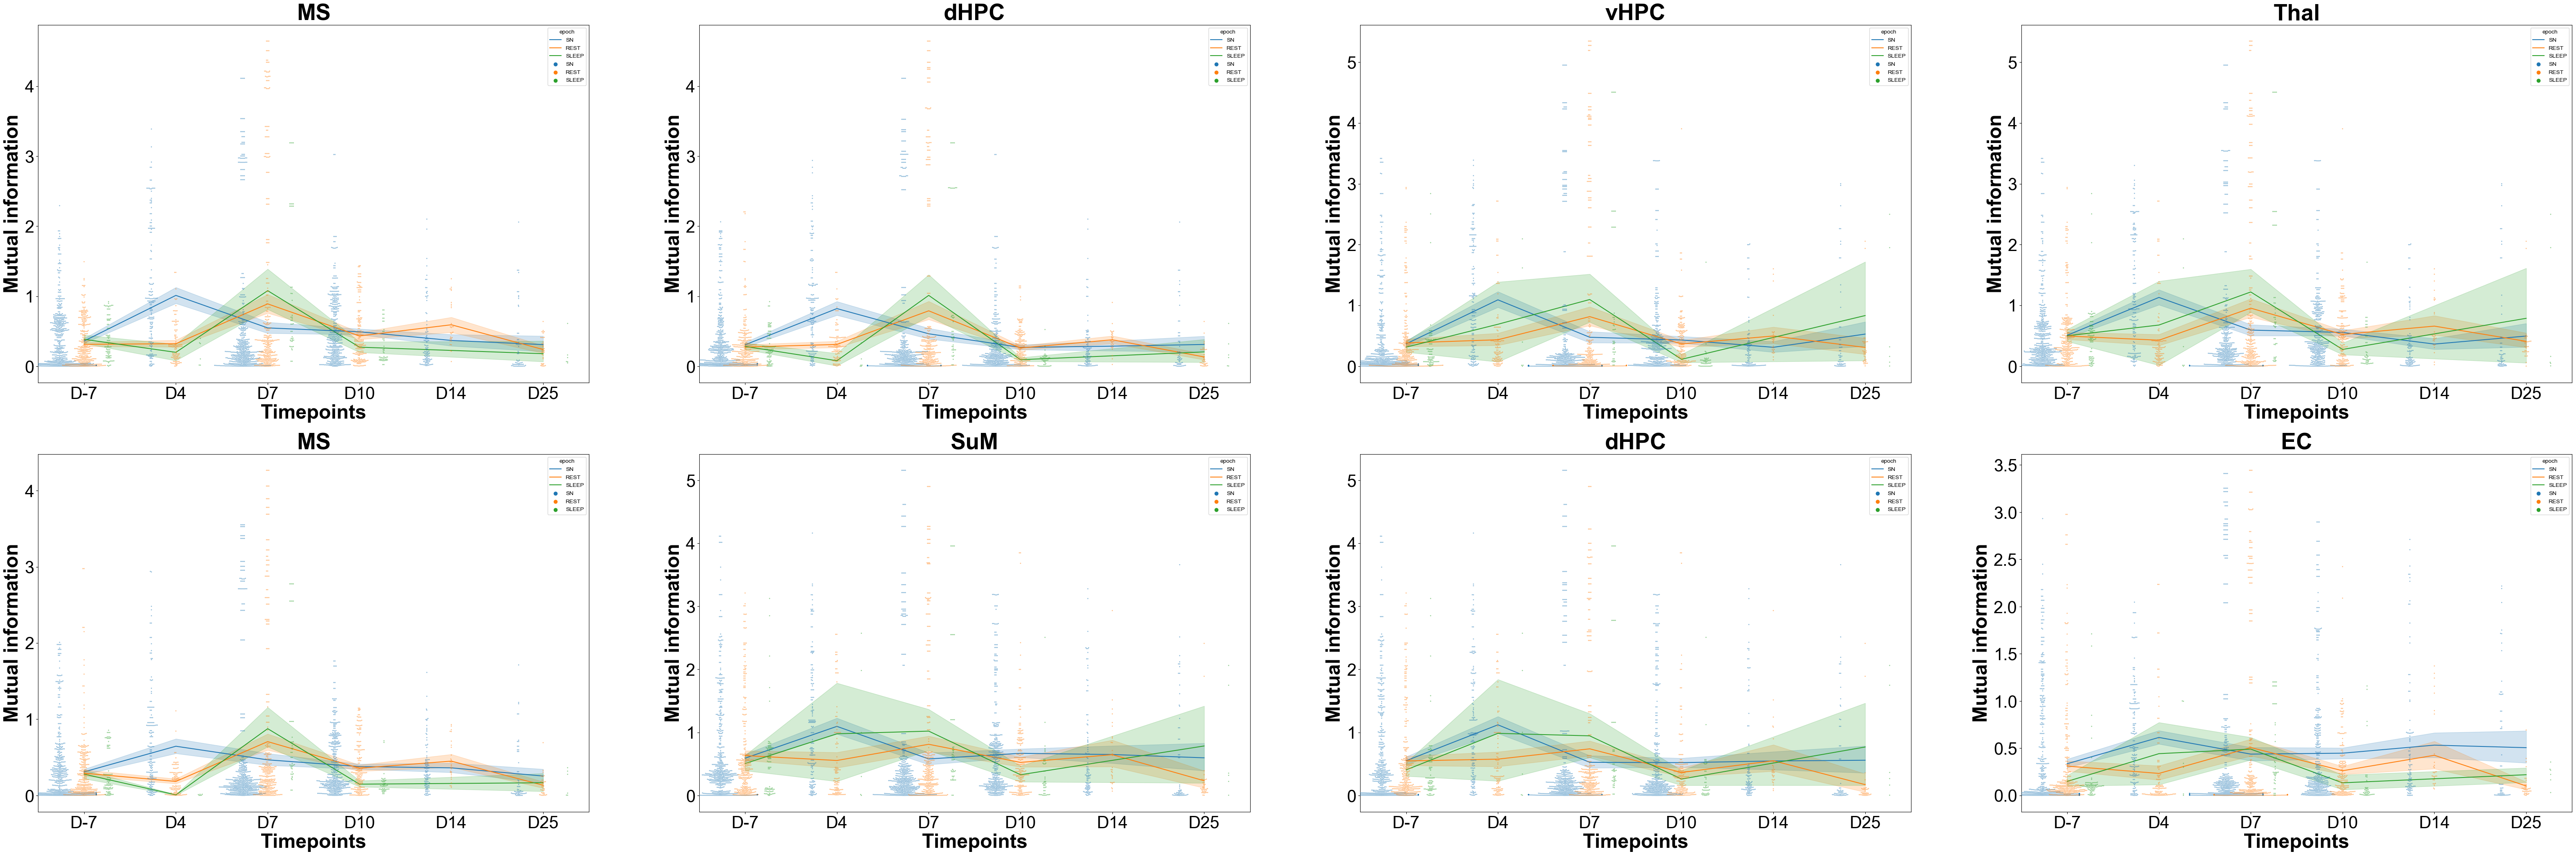

In [62]:
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(80, 25))
axes_number_i=0
axes_number_j=0
plt.subplots_adjust(hspace=0.2, wspace=0.2)
# for n_group in df.group.unique():
for n_group in [5,3]:
    df_mi=pd.DataFrame([])
    for epoch in ['SN','VC','SLEEP']:
        df_mi_epoch=get_mi_epoch(df,n_group,epoch)
        df_mi_epoch=pd.melt(df_mi_epoch,id_vars='timepoint').rename(columns={'variable':'region'})
        df_mi_epoch=df_mi_epoch.explode('region')
        df_mi_epoch['epoch']=epoch
        df_mi=pd.concat([df_mi,df_mi_epoch])
    for region in df_mi.region.unique():
        df_plot=df_mi[df_mi.region==region]
        timepoints = sort_date(all_timepoints,df_plot.timepoint.unique().tolist())
        df_plot['timepoint'] = pd.Categorical(
        df_plot['timepoint'], 
        categories=timepoints, 
        ordered=True)
        df_plot.epoch=df_plot.epoch.apply(lambda x: rename_epoch(x))
        # plt.close()
        # sns.lineplot(df_plot,x='timepoint',y='value',hue='epoch',palette=palette_epoch,ax=axs[axes_number_i,axes_number_j])
        # sns.swarmplot(data=df_plot, x="timepoint", y='value', alpha=.5,dodge=True,size=2,hue='epoch',palette=palette_epoch,ax=axs[axes_number_i,axes_number_j])
        # # plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0,fontsize=12)

        # axs[axes_number_i,axes_number_j].set_title(f'Average mutual information - {region}', fontsize=17, fontweight='bold')
        
        # axs[axes_number_i,axes_number_j].set_xlabel('Timepoints', fontweight='bold', fontsize=15)
        # axs[axes_number_i,axes_number_j].set_ylabel('Mutual information', fontweight='bold', fontsize=15)
        # axs[axes_number_i,axes_number_j].set_xticklabels(axs[axes_number_i,axes_number_j].get_xticklabels(), fontweight='bold', fontsize=12)
        # axs[axes_number_i,axes_number_j].set_yticklabels(axs[axes_number_i,axes_number_j].get_yticklabels(), fontweight='bold', fontsize=12)
        
        # plt.savefig(SAVE_PATH_FIG/f'group {n_group}'/'raw_data'/f'mutual_information_{region}_regional',dpi=300,bbox_inches='tight')
        # plt.close()

        sns.lineplot(df_plot,x='timepoint',hue='epoch',y='value',ax=axs[axes_number_i,axes_number_j])
        sns.swarmplot(data=df_plot, x="timepoint", y='value',hue='epoch', alpha=.5,dodge=True,size=2,ax=axs[axes_number_i,axes_number_j])
        axs[axes_number_i,axes_number_j].set_title(f'{region}', fontsize=40, fontweight='bold')
        
        
        axs[axes_number_i,axes_number_j].set_xlabel('Timepoints', fontweight='bold', fontsize=35)
        axs[axes_number_i,axes_number_j].set_ylabel('Mutual information', fontweight='bold', fontsize=35)    
        axs[axes_number_i,axes_number_j].set_xticklabels(axs[axes_number_i,axes_number_j].get_xticklabels(), fontsize=30)
        axs[axes_number_i,axes_number_j].set_yticklabels(axs[axes_number_i,axes_number_j].get_yticklabels(), fontsize=30)
        axes_number_j+=1
    axes_number_j=0
    axes_number_i+=1
plt.savefig(SAVE_PATH_FIG/f'11_2_average_mutual_information_regional.svg',dpi=300,bbox_inches='tight')


        

/tmp/ipykernel_67109/716309587.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), fontweight='bold', fontsize=12)
/tmp/ipykernel_67109/716309587.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontweight='bold', fontsize=12)
/home/morteza/anaconda3/lib/python3.10/site-packages/seaborn/categorical.py:3540: UserWarning: 51.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/morteza/anaconda3/lib/python3.10/site-packages/seaborn/categorical.py:3540: UserWarning: 54.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/morteza/anaconda3/lib/python3.10/site-packages/seaborn/categorical.py:3540: UserWarning: 38.9% of the points cannot be placed; you may want to decreas

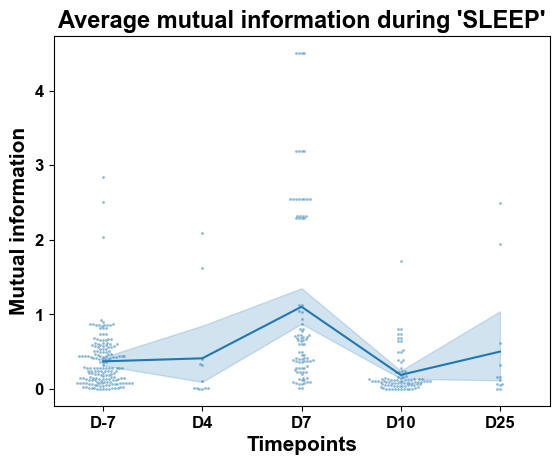

In [70]:
for n_group in [3,5]:
    for epoch in ['SN','VC','SLEEP']:
        df_mi_epoch=get_mi_epoch(df,n_group,epoch)
        df_mi_epoch=pd.melt(df_mi_epoch,id_vars='timepoint').rename(columns={'variable':'region'})
        df_mi_epoch['epoch']=epoch
        plt.close()
        df_mi_epoch.epoch=df_mi_epoch.epoch.apply(lambda x: rename_epoch(x))
        timepoints = sort_date(all_timepoints,df_mi_epoch.timepoint.unique().tolist())
        df_mi_epoch['timepoint'] = pd.Categorical(
        df_mi_epoch['timepoint'], 
        categories=timepoints, 
        ordered=True)
        ax=sns.lineplot(df_mi_epoch,x='timepoint',y='value',hue='region')
        legend=plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0,fontsize=12)
        plt.title(f'Average pairwise mutual information during {rename_epoch(epoch)}', fontsize=17, fontweight='bold')
        plt.ylabel('Mutual information', fontweight='bold', fontsize=15)
        plt.xlabel('Timepoints', fontweight='bold', fontsize=15)

        for text in legend.get_texts():
            text.set_text(text.get_text().strip("()").replace("'",''))
        
        ax.set_xticklabels(ax.get_xticklabels(), fontweight='bold', fontsize=12)
        ax.set_yticklabels(ax.get_yticklabels(), fontweight='bold', fontsize=12)
        
        plt.savefig(SAVE_PATH_FIG/f'group {n_group}'/'raw_data'/f'mutual_information_{epoch}_pairwise',dpi=300,bbox_inches='tight')
        plt.close()

        ax=sns.lineplot(df_mi_epoch,x='timepoint',y='value')
        sns.swarmplot(data=df_mi_epoch, x="timepoint", y='value', alpha=.5,dodge=True,size=2)
        plt.title(f'Average mutual information during {rename_epoch(epoch)}', fontsize=17, fontweight='bold')
        plt.xlabel('Timepoints', fontweight='bold', fontsize=15)
        plt.ylabel('Mutual information', fontweight='bold', fontsize=15)

        ax.set_xticklabels(ax.get_xticklabels(), fontweight='bold', fontsize=12)
        ax.set_yticklabels(ax.get_yticklabels(), fontweight='bold', fontsize=12)
        
        plt.savefig(SAVE_PATH_FIG/f'group {n_group}'/'raw_data'/f'mutual_information_{epoch}',dpi=300,bbox_inches='tight')

